In [2]:
%autosave 0

Autosave disabled


In [3]:
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import sys
sys.path.append('..')

##Custom Lib
import lib
from lib.data_clean import DataClean
from lib.classifier_trainer import ClassifierJob, MainAiJob
from lib.plot import roc
##

# Import ML modele packages
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
import xgboost as xgb
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm

# Introduction

Objectif :
  - Trouver le meilleur modèle, dans ce notebook je vais iterer et tester des conbinaisons, evaluer les resultats et determiner le meilleur modèle, qui sera dans la prochaine étape scélle dans un pipeline d'entrainement et droper pour utlisation. 
  - Tester avec le moins de variables possibles pour qu'ils puissent en recuperer plus et faire grossir le dataset

In [4]:
init_df = pd.read_excel("../data/Données projet LAP Cas-témoin 02-10-20.xlsx")
df = init_df

In [4]:
## clean des datas
cleandata = DataClean(df)
df_clean = cleandata.clean_job()

In [5]:
pd.set_option('display.max_columns', df_clean.shape[1])

In [6]:
df_clean.head(5)

,target,Age,Sex_M_F_(0_1),Leucocytes_(G_L),Hematies_(T_L),Hemoglobine_(g_L),Hematocrite_(%),VGM_(fL),TCMH_(pg),CCMH_(g_L),IDR-CV_(%),PNN_(%),PNN_(G_L),PNE_(%),PNE_(G_L),PNB_(%),PNB_(G_L),Lymphos_(%),Lymphos_(G_L),Mono_(%),Mono_(G_L),Blastes_(%),Plq_(G_L),VPM_(fL),Ret_(G_L),TP_(%),Ratio_TCA_,Fibrinogene_(g_L),PDF_(ug_mL)_,LDH_(U_L),Calcium_(Ca2+)_(mmol_L),Phosphore_(mmol_L),Uree_(mmol_L),Creatinine,Acide_urique_(umol_L),Ferritine_(ug_L),CRP_(mg_L)
0,0.0,47.227397,0.0,323.00,2.915,70.0,27.0,93.45,32.0,339.0,15.95,0.0,0.00,0.0,0.0,0.0,0.0,20.0,1.63,2.0,0.10,98.0,32.0,10.4,37.2,51.0,1.60,4.20,44.02,2711.0,2.295,1.05,5.5,126.0,776.0,694.0,38.1
1,0.0,36.463014,1.0,1.30,2.380,86.0,26.0,107.10,36.1,337.0,17.50,3.0,0.04,0.0,0.0,0.0,0.0,66.0,0.86,0.0,0.00,31.0,57.0,11.2,37.2,100.0,0.87,3.86,44.02,227.0,2.490,0.80,3.8,59.0,322.0,316.0,24.0
2,0.0,15.306849,0.0,0.55,3.460,95.0,26.0,74.30,27.5,370.0,12.30,0.0,0.00,0.0,0.0,0.0,0.0,60.0,0.33,4.0,0.02,36.0,17.0,9.0,37.2,71.0,0.94,3.06,44.02,352.5,2.295,1.05,5.5,76.0,322.0,694.0,21.6
3,0.0,75.115068,0.0,7.68,2.915,91.0,27.0,93.45,32.0,339.0,15.95,14.0,1.06,0.0,0.0,0.0,0.0,20.0,1.63,2.0,0.10,42.0,51.0,10.4,37.2,71.0,0.94,3.06,44.02,352.5,2.295,1.05,5.5,76.0,322.0,694.0,21.6
4,0.0,54.876712,1.0,125.52,2.950,101.0,29.0,97.60,34.2,351.0,15.90,1.0,1.26,0.0,0.0,0.0,0.0,4.0,5.02,0.0,0.00,95.0,50.0,11.2,37.2,60.0,0.87,3.89,40.00,1961.0,2.270,0.99,4.0,64.0,440.0,1960.0,71.9


In [7]:
## Je définis la taille en % du test_set  0.3 pour un gros data set sinon 0.2
test_size=0.2

## Je définis une seed afin d'avoir un reproductibilité dans mon expérience 
## afin de bien comparer ma modélisation dans le même contexte
random_state= 69

In [8]:
## je crée un dictionnaire de model que je souhaite tester

dict_models ={
              "Random Forest ":RandomForestClassifier(),
              "Gradient Boosting Classifier": GradientBoostingClassifier(),
              "AdaBoost Classifier": AdaBoostClassifier(),
              "XgBoost": xgb.XGBClassifier(),
              "Decision Tree": DecisionTreeClassifier(), 
              "LR": LogisticRegression(max_iter=1000), 
              "SVM":svm.SVC(kernel='poly'),
             }

In [9]:
drop_col = ['Sex_M_F_(0_1)', 'Hematies_(T_L)','Mono_(G_L)',
       'Hemoglobine_(g_L)', 'Hematocrite_(%)', 'TCMH_(pg)','IDR-CV_(%)', 'PNN_(%)',
       'PNE_(G_L)', 'PNB_(%)', 'PNB_(G_L)', 'Lymphos_(G_L)',
       'Mono_(%)', 'Blastes_(%)', 'Plq_(G_L)', 'VPM_(fL)',
       'Ret_(G_L)', 'Ratio_TCA_',
       'PDF_(ug_mL)_', 'LDH_(U_L)', 'Calcium_(Ca2+)_(mmol_L)',
       'Phosphore_(mmol_L)', 'Uree_(mmol_L)', 'Creatinine',
       'Acide_urique_(umol_L)', 'Ferritine_(ug_L)', 'CRP_(mg_L)']


*********  Random Forest   *********

Score train : 1.0
-----------
Score test : 0.93
-----------
AUC: 0.95 (std:0.0146), (splits = 5)


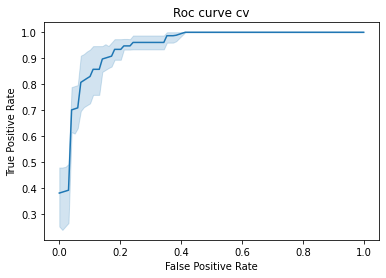

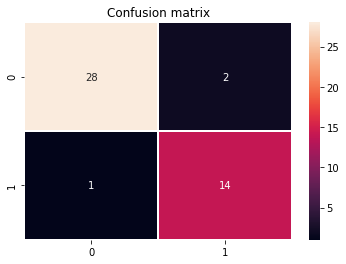

--------
Classification reporting
              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95        30
         1.0       0.88      0.93      0.90        15

    accuracy                           0.93        45
   macro avg       0.92      0.93      0.93        45
weighted avg       0.94      0.93      0.93        45



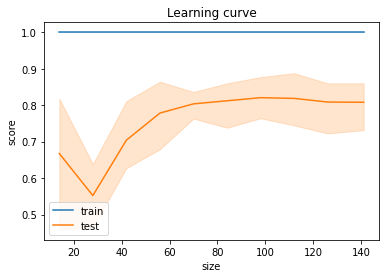

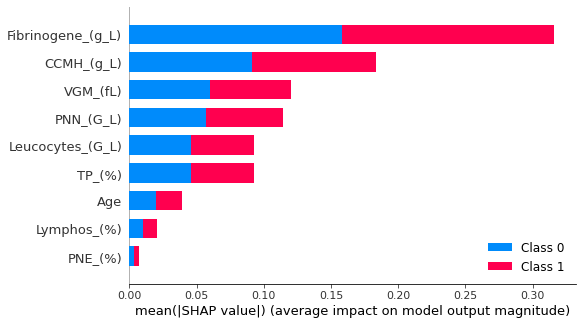

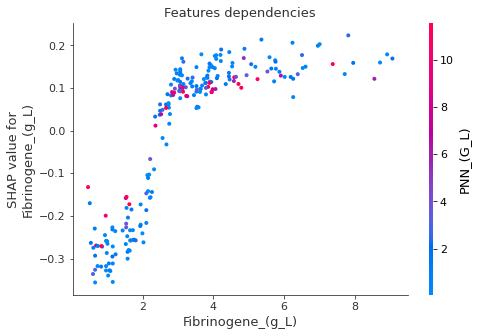


*********  Gradient Boosting Classifier  *********

Score train : 1.0
-----------
Score test : 0.87
-----------
AUC: 0.94 (std:0.0225), (splits = 5)


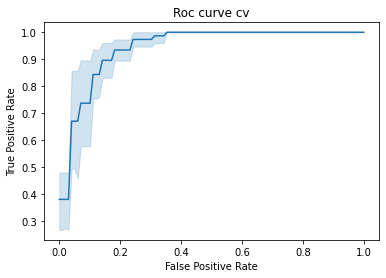

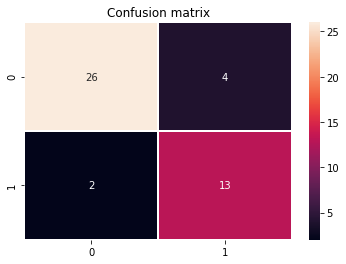

--------
Classification reporting
              precision    recall  f1-score   support

         0.0       0.93      0.87      0.90        30
         1.0       0.76      0.87      0.81        15

    accuracy                           0.87        45
   macro avg       0.85      0.87      0.85        45
weighted avg       0.87      0.87      0.87        45



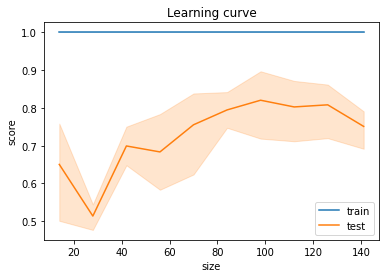

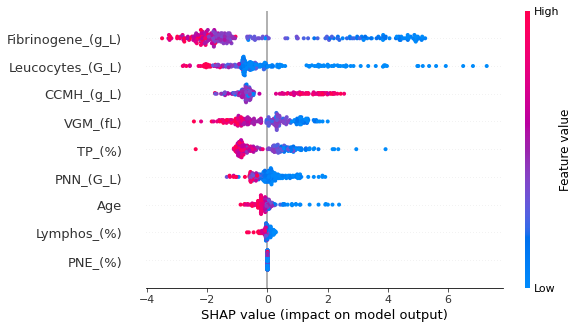

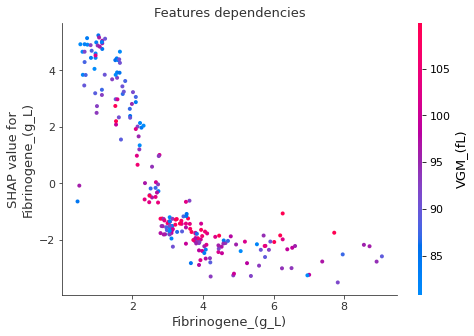


*********  AdaBoost Classifier  *********

Score train : 1.0
-----------
Score test : 0.89
-----------
AUC: 0.92 (std:0.0366), (splits = 5)


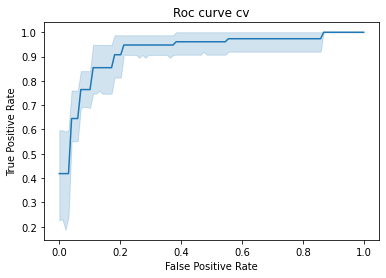

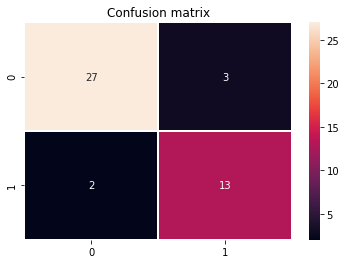

--------
Classification reporting
              precision    recall  f1-score   support

         0.0       0.93      0.90      0.92        30
         1.0       0.81      0.87      0.84        15

    accuracy                           0.89        45
   macro avg       0.87      0.88      0.88        45
weighted avg       0.89      0.89      0.89        45



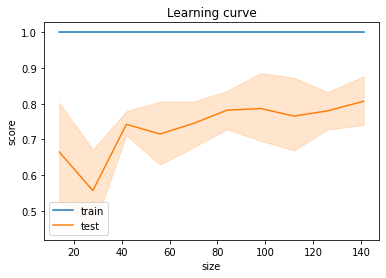

Model type not yet supported by TreeExplainer: <class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>

*********  XgBoost  *********

Score train : 1.0
-----------
Score test : 0.91
-----------
AUC: 0.95 (std:0.0199), (splits = 5)


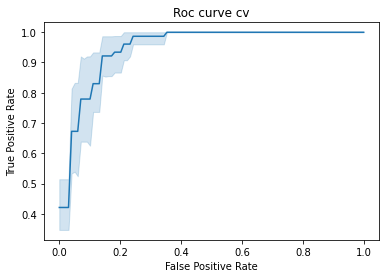

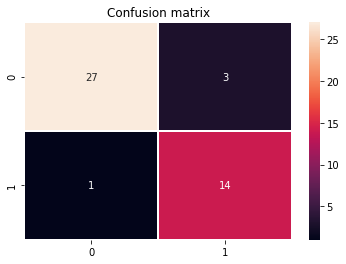

--------
Classification reporting
              precision    recall  f1-score   support

         0.0       0.96      0.90      0.93        30
         1.0       0.82      0.93      0.87        15

    accuracy                           0.91        45
   macro avg       0.89      0.92      0.90        45
weighted avg       0.92      0.91      0.91        45



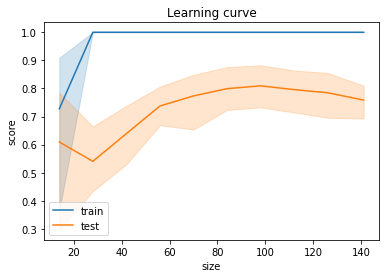

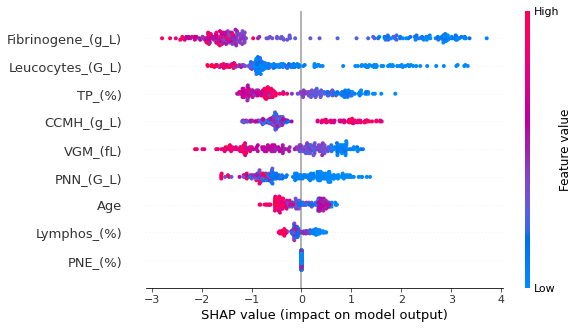

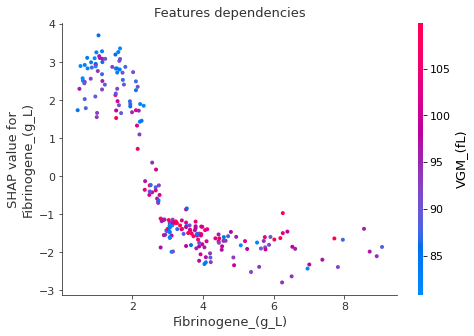


*********  Decision Tree  *********

Score train : 1.0
-----------
Score test : 0.82
-----------
AUC: 0.76 (std:0.0156), (splits = 5)


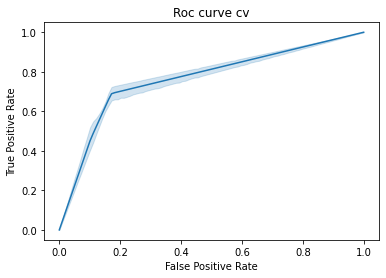

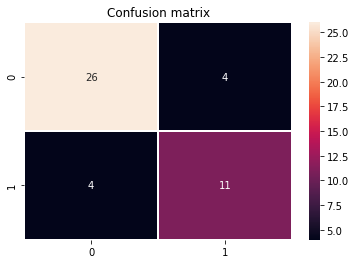

--------
Classification reporting
              precision    recall  f1-score   support

         0.0       0.87      0.87      0.87        30
         1.0       0.73      0.73      0.73        15

    accuracy                           0.82        45
   macro avg       0.80      0.80      0.80        45
weighted avg       0.82      0.82      0.82        45



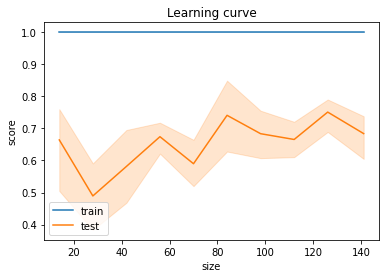

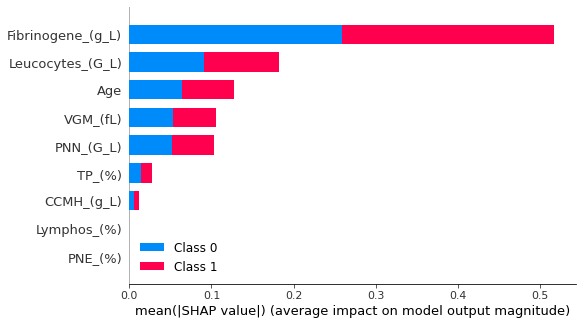

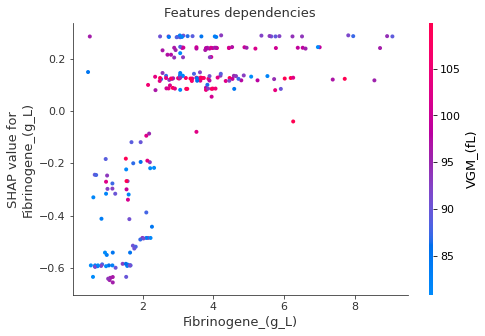


*********  LR  *********

Score train : 0.91
-----------
Score test : 0.89
-----------
AUC: 0.94 (std:0.034), (splits = 5)


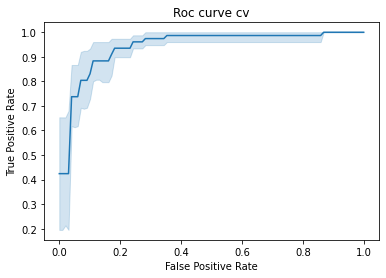

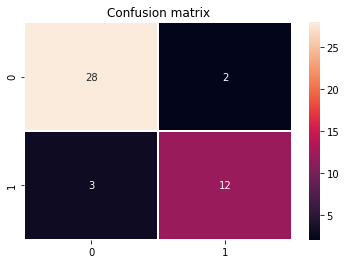

--------
Classification reporting
              precision    recall  f1-score   support

         0.0       0.90      0.93      0.92        30
         1.0       0.86      0.80      0.83        15

    accuracy                           0.89        45
   macro avg       0.88      0.87      0.87        45
weighted avg       0.89      0.89      0.89        45



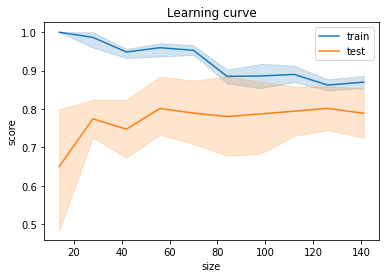

Model type not yet supported by TreeExplainer: <class 'sklearn.linear_model._logistic.LogisticRegression'>

*********  SVM  *********

Score train : 0.88
-----------
Score test : 0.84
-----------
-----------
No prob methods for this model :  predict_proba is not available when  probability=False
-----------


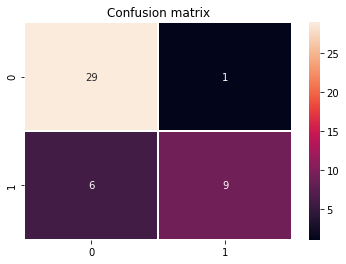

--------
Classification reporting
              precision    recall  f1-score   support

         0.0       0.83      0.97      0.89        30
         1.0       0.90      0.60      0.72        15

    accuracy                           0.84        45
   macro avg       0.86      0.78      0.81        45
weighted avg       0.85      0.84      0.83        45



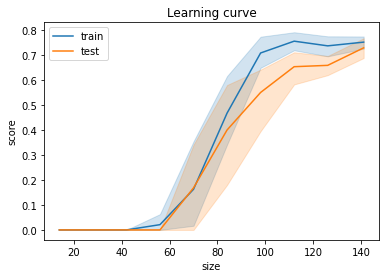

Model type not yet supported by TreeExplainer: <class 'sklearn.svm._classes.SVC'>


In [10]:
## je boucle sur mon dictionaire et appel la classe, je patiente et analyse les résulats
for name, model in dict_models.items():
    print("")
    print("********* ",name," *********")
    print("")
    AI = MainAiJob(model, df_clean, target_name='target', catagorical_features=False,
                        test_size=test_size, random_state=random_state, learning_curve_mod=True, normalize=False,
                        list_col_name_drop=drop_col,show_explainers=True)
#     model = AI.core_job()

# Amélioration du modéle

In [11]:
model_win = xgb.XGBClassifier()

Score train : 1.0
-----------
Score test : 0.91
-----------
AUC: 0.95 (std:0.0182), (splits = 5)


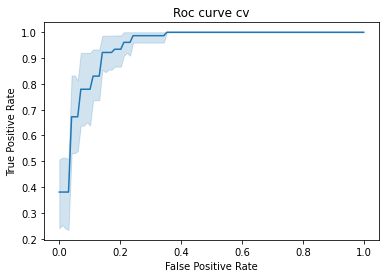

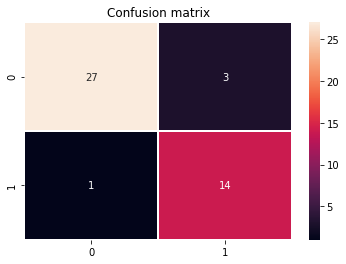

--------
Classification reporting
              precision    recall  f1-score   support

         0.0       0.96      0.90      0.93        30
         1.0       0.82      0.93      0.87        15

    accuracy                           0.91        45
   macro avg       0.89      0.92      0.90        45
weighted avg       0.92      0.91      0.91        45



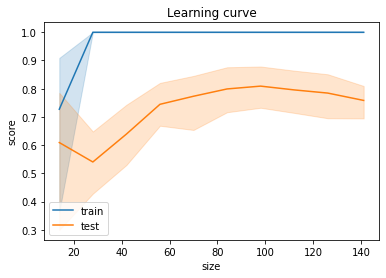

In [12]:
## je refais la modélisation mais avec la premiére méthode (classifierJob)
cl3 = ClassifierJob(df_clean, model_win)
x_full_v3, y_full_v3 = cl3.split_features_target(list_col_name_drop=drop_col) ## add here the drop job
model_fited_v2 = cl3.fit_and_eval(test_size,random_state, learning_curve_mod=True, normalize=True) ## Now normalize==true

Pas de Gain avec la normalisation, comme on perd la fonctionnalitée de shap explainer, je ne conserve pas l'idée.

In [13]:
def Best_opti(x_full,y_full,model,test_size=0.2, random_state=69, normalize=False):
    """ For classification binaries case
    Split the data, Fit the model, and return best_parameters
    
    params :
    
    x_full = features dataframe
    y_full = target dataframe
    model = model observed (not yet fitted)
    test_size  = the size of split, 0.2 by default type float
    random_state= 69 by default, make your process reproducible type int.
    normalize = Apply tandardscaler on dataset

    return : Best hyper parameters for model
    """    
    seed = random_state
    np.random.seed(seed)
    
    ##Split data in train/test using stratify = take randomly the same sample number from each class.
    X_train, X_test, y_train, y_test = train_test_split(x_full, y_full, test_size=test_size, 
                                                        random_state=seed, stratify=y_full)
    
    ######## Insert normalize job #######
    if normalize:
        scale = StandardScaler()
        X_train = scale.fit_transform(X_train)
        X_test = scale.transform(X_test)
    
    param_grid = [{'n_estimators': [150,200,300,400],'max_depth': [2,3,4,5]}]
    grid_search = GridSearchCV(model,param_grid, cv=5, scoring ='f1', return_train_score=True)
    grid_search.fit(X_train,y_train)
    
    return grid_search.best_params_

In [14]:
Best_opti(x_full_v3, y_full_v3,model_win)

{'max_depth': 2, 'n_estimators': 300}

je relance l'entrainement et evaluation mais avec les paramétres retournés par Best_opti

In [15]:
model_win_opti = xgb.XGBClassifier(n_estimators=300, max_depth=2)

Score train : 1.0
-----------
Score test : 0.93
-----------
AUC: 0.95 (std:0.02), (splits = 5)


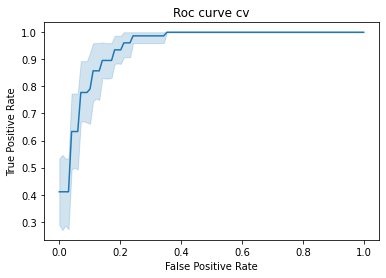

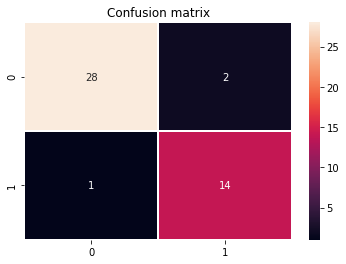

--------
Classification reporting
              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95        30
         1.0       0.88      0.93      0.90        15

    accuracy                           0.93        45
   macro avg       0.92      0.93      0.93        45
weighted avg       0.94      0.93      0.93        45



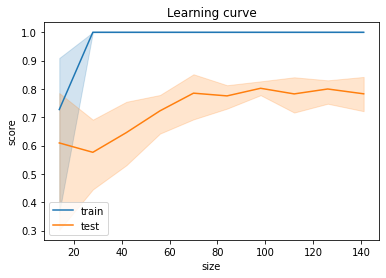

In [16]:
## Old method for training
cl4 = ClassifierJob(df_clean,model_win_opti)
x_full_v4, y_full_v4 = cl4.split_features_target(list_col_name_drop=drop_col)
model_fited_opti = cl3.fit_and_eval(test_size,random_state, learning_curve_mod=True, normalize=False)

Pas d'amélioration avec le grid search aprés plusieurs test je conserve le modèle model_win

In [17]:
model_win

XGBClassifier()

# Recherche du seuil de confiance optimal

- positif :
    - TP (True Positives) : le médecin vous annonce que vous êtes malade, et vous êtes bel et bien malade.
    - TN (True Negatives) : le médecin vous annonce que vous n’êtes pas malade, et vous n’êtes effectivement pas malade.

- negatif :
    - FP (False Positive) : le médecin vous annonce que vous êtes malade, mais vous n’êtes pas malade. ** moindre mal
    - FN (False Negative) : le médecin vous annonce que vous n’êtes pas malade, mais vous êtes malade. ** worst

AUC: 0.9458409961685823 (std:0.029775348411027)
AUC: 0.947167049808429 (std:0.03329566620184383)


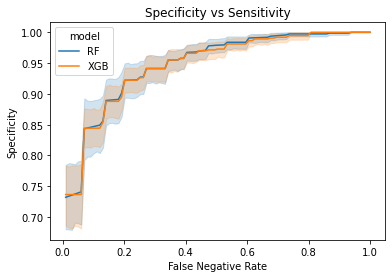

In [18]:
result_xgb, aucs = roc.roc_curve_cv(xgb.XGBClassifier(), x_full_v3, y_full_v3, n_splits=5, n_repeats=5)
print(f"AUC: {np.mean(aucs)} (std:{np.std(aucs)})")
result_rf, aucs = roc.roc_curve_cv(RandomForestClassifier(), x_full_v3, y_full_v3, n_splits=5, n_repeats=5)
print(f"AUC: {np.mean(aucs)} (std:{np.std(aucs)})")


roc.plot_specificity_cv({'XGB': result_xgb, 'RF':result_rf}, invert_x=True, invert_y=False)
plt.show()

In [29]:
# for i in x_full_v3:
#     sns.displot(x_full_v3[f'{i}'])

Best threshold: 0.25252525252525254
Best cost: 131.06667639750626


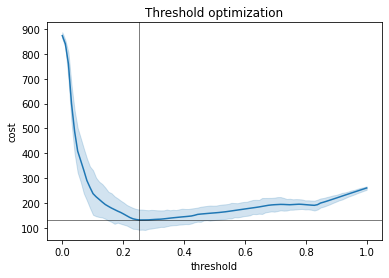

In [19]:
cl3.optimize_model(minimize=True)

[(0.0, 1.0), (0.0, 1.0)]

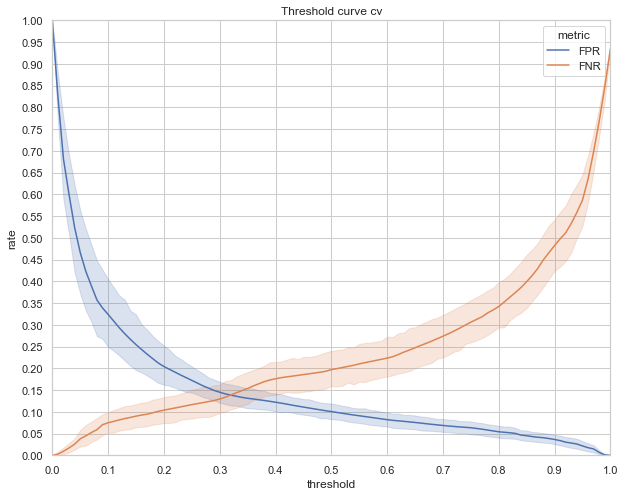

In [28]:
fig, ax = plt.subplots(figsize=(10,8))
sns.set(style="whitegrid")
roc_fig = roc.plot_roc_threshold_cv(result_xgb,
                        tpr=False,
                        fpr=True,
                        tnr=False,
                        fnr=True,)

roc_fig.set_yticks(np.arange(0,1.05,0.05));
roc_fig.set_xticks(np.arange(0,1.05,0.1));
roc_fig.set(xlim=(0,1),ylim=(0,1))

# Calibration du model

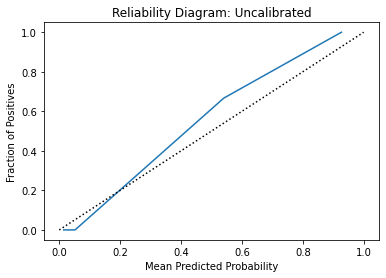

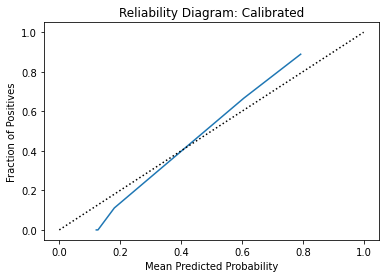

Brier score  =  0.023856650557768734


In [20]:
model_win_calibrated = cl3.Calibrate_fited_model(n_bins=5)

La calibration n'est pas effective, nous avons pas assez de données

# --Fin--